<a href="https://colab.research.google.com/github/taylorfrancisco/Example-Work/blob/main/Negative_Binomial_Model_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [ ]:
from __future__ import division
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import scipy as sp

In [ ]:
# upload data
from google.colab import files
uploaded= files.upload()
import io
d = pd.read_csv(io.BytesIO(uploaded['GSS.2006 (1).csv']))

KeyboardInterrupt: ignored

# Variables

For my dependent variable I will explore mental health using the mntlhlth variable. This variable comes from the following question: Now thinking about your mental health, which includes stress, depression, and problems with emotions, for how many days during the past 30 days was your mental health not good?

I will also note I am only using data from 2006.


As this is a count variable, a Poisson regression is the appropriate regression type to use.

In [ ]:
d.mntlhlth.describe()

count    1717.000000
mean        3.000000
std         6.681656
min         0.000000
25%         0.000000
50%         0.000000
75%         3.000000
max        30.000000
Name: mntlhlth, dtype: float64

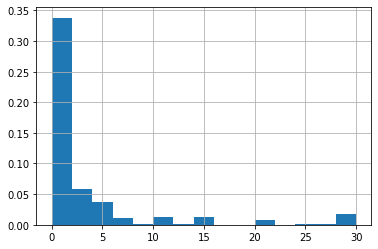

In [ ]:
d.mntlhlth.hist(bins=15, density=True)

In [ ]:
d.mntlhlth.var()

44.64452214452214

The mean (3) is not equal to the variance (45), which suggess that a normal Poisson regression is not ideal,a negative binomial is more appropriate. Additionally, from the histogram, it appears that there is a large amount of "zero" responses, which suggests that a zero-inflated negative binomial would be most appropriate to use.

In [ ]:
variables = ['mntlhlth', 'realinc','socfrend', 'sex']
#recode to make more interpretable
d = d[variables].copy()
d['socfrend'] = 7 - d.socfrend
d['inc10k'] = d.realinc/10000
d_noNA = d.dropna()


  The independent variables I will explore are income and frequency of time spent with friends. I am mainly interested in how frequency of time spent with friends impacts mental health, particularly in light of the pandemic where socializing was drastically decreased and we saw a lot of mental health issues increase. As such, I hypothesize that the more frequently a person spends time with friends, the fewer days of poor mental health they will have.
  
  I will include real income as a control variable as the effects of income on mental health are well known (the more money you have the less financial stress you have to endure, generally allowing for better mental health). I suspect that the more money a person makes the fewer poor mental health days they would experience.

  I will lastly include sex of the respondent as another variable to act as a control, as there may be sex differences in mental health. Particularly women are more likely to be depressed and thus may have more poor mental health days.





The friend variable I am using is socfrend which comes from the following question:

  Would you use this card and tell me which answer
  comes closest to how often you do the following
  things…
  C. Spend a social evening with friends who live
  outside the neighborhood?

Which had the following possible responses.
      -100	.i: Inapplicable
      -99	.n: No answer
      -98	.d: Do not Know/Cannot Choose
      -97	.s: Skipped on Web
      1	ALMOST DAILY
      2	SEV TIMES A WEEK
      3	SEV TIMES A MNTH
      4	ONCE A MONTH
      5	SEV TIMES A YEAR
      6	ONCE A YEAR
      7	NEVER


  To make this variable easier to interpret, I recoded it to be 1 as being never and 7 as being almost daily so an increase in number corresponds with the increase of time spent with friends.

  I will also exclude the various non-answers (-97 to -100) in my models by subsetting the data.

  Additionally, to make income more interpretable I recoded it to be inc10k so it is for every increase in 10 thousand dollars instead of increase in 1 dollar.

# OLS

In [ ]:
from statsmodels.regression.linear_model  import OLS
m1 = OLS.from_formula('mntlhlth ~ inc10k + socfrend + C(sex)', data =d, subset=d.socfrend>0).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               mntlhlth   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     7.424
Date:                Wed, 22 Feb 2023   Prob (F-statistic):           6.41e-05
Time:                        20:44:21   Log-Likelihood:                -3300.6
No. Observations:                1007   AIC:                             6609.
Df Residuals:                    1003   BIC:                             6629.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       2.6786      0.620      4.318      0.000       1.461       3.896
C(sex)[T.2]     0.4604      0.408      1.128      0.260      -0.340       1.261
inc10k         -0.2488      0.062     -3.982      0.000      -0.371      -0.126
socfrend        0.2672      0.131      2.033      0.042       0.009       0.525
==============================================================================
Omnibus:                      612.244   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4186.364
Skew:                           2.873   Prob(JB):                         0.00
Kurtosis:                      11.171   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
m1.predict(d[['inc10k', 'socfrend', 'sex']]).describe()

count    1721.000000
mean        3.155762
std         0.979095
min        -0.649254
25%         2.718843
50%         3.284597
75%         3.771407
max         5.002692
dtype: float64

As expected, the OLS is not appropriate as it gave negative predicted values, which do not make sense given the variable mntlhealth is a count that can only go from 0-30. Additionally, it only predicts a maximum of 5 days of poor mental health where there was a large skew above 5 days in the dataset, indicating that there could be a model that would give more accurate predictions.

The value of r and adjusted r-squared are also very low at 0.019 and 0.017 respectively, which suggests it may not be a very good predictive model




# Poisson

In [ ]:
m2 = smf.poisson('mntlhlth ~ inc10k + socfrend + C(sex)', data =d, subset=d.socfrend>0).fit()
m2.summary()

Optimization terminated successfully.
         Current function value: 4.783848
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:               mntlhlth   No. Observations:                 1007
Model:                        Poisson   Df Residuals:                     1003
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 Feb 2023   Pseudo R-squ.:                 0.03653
Time:                        20:44:59   Log-Likelihood:                -4817.3
converged:                       True   LL-Null:                       -5000.0
Covariance Type:            nonrobust   LLR p-value:                 7.254e-79
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.0800      0.058     18.561      0.000       0.966       1.194
C(sex)[T.2]     0.1502      0.037      4.034      0.000       0.077       0.223
inc10k         -0.1190      0.008    -14.843      0.000      -0.135      -0.103
socfrend        0.0836      0.011      7.391      0.000       0.061       0.106
===============================================================================
"""

According to this model, with every increase in frequency of time spent with friends, is a 0.08 higher expected log-count of days with poor mental health, net of other factors. This is a significant increase, but is not what I would have expected.

For every 10,000 dollar increase in income, there is a 0.1190 lower expected log-count of days spent with poor mental health. This is also significant and aligns with my previous hypothesis.

Females compared to males have a 0.1502 higher expected log-count of days with more mental health, net all other factors. This aligns with my earlier hypothesis and is a significant increase.

However, this does not address the overdispersion of the dependent variable. As such, a negative binomial should be run instead.

# Negative Binomial

In [ ]:
from statsmodels.discrete.discrete_model import NegativeBinomial
nb1 = NegativeBinomial.from_formula('mntlhlth ~ inc10k + socfrend + C(sex)', data =d, subset=d.socfrend>0).fit()
nb1.summary()

Optimization terminated successfully.
         Current function value: 1.760224
         Iterations: 14
         Function evaluations: 21
         Gradient evaluations: 21


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:               mntlhlth   No. Observations:                 1007
Model:               NegativeBinomial   Df Residuals:                     1003
Method:                           MLE   Df Model:                            3
Date:                Wed, 22 Feb 2023   Pseudo R-squ.:                0.004917
Time:                        20:45:07   Log-Likelihood:                -1772.5
converged:                       True   LL-Null:                       -1781.3
Covariance Type:            nonrobust   LLR p-value:                 0.0005528
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9747      0.237      4.109      0.000       0.510       1.440
C(sex)[T.2]     0.1486      0.162      0.919      0.358      -0.168       0.465
inc10k         -0.0875      0.022     -3.937      0.000      -0.131      -0.044
socfrend        0.0836      0.052      1.621      0.105      -0.018       0.185
alpha           6.0533      0.406     14.926      0.000       5.258       6.848
===============================================================================
"""

As the alpha parameter is statistically significant, this suggest that the Poisson was not the most appropriate model, and we are correct in using the negative binomial model instead.

According to this model, with every increase in frequency of time spent with friends, is a 0.0836 higher expected log-count of days with poor mental health, net of other factors. This is no longer a significant increase however.

For every 10,000 dollar increase in income, there is a 0.0875	lower expected log-count of days spent with poor mental health. This is significant and aligns with my previous hypothesis.

Females compared to males have a 0.1486 higher expected log-count of days with more mental health, net all other factors, though this is not a significant difference.

Both sex and time spent with friends were not significant, which is counter to what I previously assumed.

In [ ]:
np.exp(nb1.params)

Intercept      2.688801
C(sex)[T.2]    1.163486
inc10k         0.909371
socfrend       1.089861
dtype: float64

Another way to interpret this model is to look at the incident rate ratios above.

Females have an incident rate ratio (for poor mental health days) that is approximately 1.2 times higher, net of frequency of time spent with friends and income.

With every increase in 10,000 dollars of income, the incident rate ratio is approximately 0.9 times higher, net of all other factors.

With every marginal increase in frequency of time spent with friends, the incident rate ratio is approximately 1.1 times higher, net of all other factors.



# Zero-inflated Negative Binomial

In [ ]:
znb1 = nb1 = sm.GLM.from_formula('mntlhlth ~ inc10k + socfrend + C(sex)', data =d, subset=d.socfrend>0, family=sm.families.NegativeBinomial()).fit()
znb1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               mntlhlth   No. Observations:                 1007
Model:                            GLM   Df Residuals:                     1003
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2204.6
Date:                Wed, 22 Feb 2023   Deviance:                       2406.7
Time:                        22:05:51   Pearson chi2:                 3.61e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9891      0.114      8.685      0.000       0.766       1.212
C(sex)[T.2]     0.1514      0.074      2.039      0.041       0.006       0.297
inc10k         -0.0950      0.013     -7.492      0.000      -0.120      -0.070
socfrend        0.0860      0.024      3.639      0.000       0.040       0.132
===============================================================================
"""

According to this model, with every increase in frequency of time spent with friends, is a 	0.0860 higher expected log-count of days with poor mental health, net of other factors. This is now significant again in this model, which aligns with my hypothesis.

For every 10,000 dollar increase in income, there is a 0.0950	lower expected log-count of days spent with poor mental health. This is significant and aligns with my previous hypothesis.

Females compared to males have a 0.1514 higher expected log-count of days with more mental health, net all other factors. This is also significant and aligns with my previous assumptions.  


# Comparing Models


In [ ]:
def augment(fit, data, y):
    df = data.copy()
    df['fitted']  = fit.fittedvalues
    df['absdiff']  = np.abs(df.fitted - df[y])
    return df
data = d[['mntlhlth', 'inc10k', 'socfrend', 'sex']].copy()
data = data[data.socfrend>0]
a = augment(m1, data, 'mntlhlth')
b = augment(m2, data, 'mntlhlth')
c = augment(nb1, data, 'mntlhlth')
d = augment(znb1, data, 'mntlhlth')

In [ ]:
pd.concat({'OLS': a.absdiff.describe(), 'Poisson': b.absdiff.describe(),
           'Negative binomial': c.absdiff.describe(),
           'Zero-inflated NB': d.absdiff.describe()}, axis=1)

,OLS,Poisson,Negative binomial,Zero-inflated NB
count,1007.000000,1007.000000,1007.000000,1007.000000
mean,3.972498,3.200709,3.944721,3.944721
std,5.040007,5.915379,5.044245,5.044245
min,0.015604,0.024472,0.028221,0.028221
25%,1.886836,0.874289,1.881954,1.881954
50%,2.843877,1.137268,2.729740,2.729740
75%,3.571564,1.722337,3.490840,3.490840
max,27.423365,29.111711,27.495331,27.495331


The average absolute deviations are
lowest for Poisson, and much more behaved at the 3rd
quartile of deviations, which again suggests that Poisson is the right route to go. However, as discussed above the alpha value suggests that the negative binomial model is the better model considering the over-dispersed nature of the dependent variable.

Additionally, since the negative binomial and the zero-inflated negative binomial have the same absolute deviations, this suggest that the zero-inflated negative binomial is not giving any additional information from the negative binomial. This suggests that the negative binomial is the best predictive model.

# Predicted Values

In [ ]:

sub = data[data.socfrend>0]
newdata = pd.DataFrame({'inc10k': sub.inc10k.mean(),
                        'socfrend': sub.socfrend.mean(),
                        'sex': [1, 2]})
nb1.predict(newdata)

0    2.750133
1    3.199742
dtype: float64

Females (3.2) have more poor mental health days than males (2.8), with all else at means. This is not significant according to the model however.

In [ ]:
newdata2 = pd.DataFrame({'inc10k': sub.inc10k.mean(),
                         'sex' : 1,
                        'socfrend': [1, 2, 3,4, 5, 6, 7]})
nb1.predict(newdata2)

0    2.131234
1    2.322748
2    2.531472
3    2.758952
4    3.006873
5    3.277072
6    3.571552
dtype: float64

For males with income set at the mean, those who spend the most time with friends (3.6)have more poor mental health days than those who spend the least amount of time with friends (2.1). This is a difference of 1.5 days. As you increase in time spent with friends, all the predicted values also increase, which is contrary to my hypothesis, but it is not a significant increase according to the model.

In [ ]:
newdata3 = pd.DataFrame({'inc10k': sub.inc10k.mean(),
                         'sex' : 2,
                        'socfrend': [1, 2, 3,4, 5, 6, 7]})
nb1.predict(newdata3)

0    2.479662
1    2.702486
2    2.945333
3    3.210003
4    3.498456
5    3.812829
6    4.155452
dtype: float64

For females with income set at the mean, those who spend the most time with friends (4.2)have more poor mental health days than those who spend the least amount of time with friends (2.5). This is a difference of around 2 days. As you increase in time spent with friends, all the predicted values also increase, which is contrary to my hypothesis, but it is not a significant increase according to the model.

# Conclusion


Due to the over-dispersed nature of the dependent variable, confirmed by a significant alpha value of the negative binomial model, the negative binomial model is the best model to use as the zero-negative binomial model did not have a lower absolute deviation.

Since the negative binomial model is the most appropriate, the coefficients from that model are the most trustworthy. In that model time spent with friends was not a significant predictor of number of poor mental health days. This is surprising as I thought that more time with friends would improve your mental health, resulting in fewer poor mental health days. This is not as big of a factor as I thought it would be when controlling for income and sex.

Females were non-significantly different from the males, which is not what I expected.

As predicted, higher income was significantly associated with fewer poor mental health days, net of all factors.